In [1]:
import pandas as pd
import matplotlib.pyplot as pl
import numpy as np
import math
from sklearn import preprocessing
from sklearn import metrics
import seaborn as sns

from ProjectTools import OpenBeds


In [2]:
dry = True

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    nano_mc_df = OpenBeds.get_nanopore_twoMod(nano_2mod_path) # easier just to overwrite nano_mc
    wgbs_df = OpenBeds.get_wgbs(wgbs_bed_path)
    tab_df = OpenBeds.get_tab(tab_bed_path)

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    tab_bed_path = './data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    wgbs_df = OpenBeds.get_wgbs(wgbs_bed_path)
    tab_df = OpenBeds.get_tab(tab_bed_path)
    nano_mc_df, nano_hmc_df = OpenBeds.get_nanopore_threeMod(nano_3mod_path)
    nano_mc_df = OpenBeds.get_nanopore_twoMod(nano_2mod_path)

def filter_on_depth(df):
    average = df["readCount"].mean()
    df = df[df["readCount"].ge(10)]
    df = df[df["readCount"].le(average + 3*math.sqrt(average))]
    # df = df.loc[df["readCount"] == 15] # Testing constant readcount

    return df

ecdf_df = pd.concat([filter_on_depth(wgbs_df), 
filter_on_depth(nano_mc_df), 
filter_on_depth(tab_df), 
filter_on_depth(nano_hmc_df)], 
ignore_index=True)

merged_5mc_df = pd.merge(filter_on_depth(wgbs_df), filter_on_depth(nano_mc_df), on=["chromosome", "chromStart", "chromEnd"], suffixes=["_WGBS", "_Nano"]).reset_index()
merged_5hmc_df = pd.merge(filter_on_depth(tab_df), filter_on_depth(nano_hmc_df), on=["chromosome", "chromStart", "chromEnd"], suffixes=["_TAB", "_Nano"]).reset_index()

merged_5mc_df["WGBS_bin"] = pd.cut(merged_5mc_df["percentMeth_WGBS"], 20)
merged_5hmc_df["TAB_bin"] = pd.cut(merged_5hmc_df["percentMeth_TAB"], 20)

mc_lineplot_df = pd.DataFrame(merged_5mc_df.groupby("WGBS_bin").median(numeric_only=True)["percentMeth_Nano"])
hmc_lineplot_df = pd.DataFrame(merged_5hmc_df.groupby("TAB_bin").median(numeric_only=True)["percentMeth_Nano"])

merged_5mc_df["binarised"] = preprocessing.binarize(merged_5mc_df[["percentMeth_WGBS"]], threshold=50.0)
merged_5hmc_df["binarised"] = preprocessing.binarize(merged_5hmc_df[["percentMeth_TAB"]], threshold=40.0)   

mc_fpr, mc_tpr, mc_threshold = metrics.roc_curve(merged_5mc_df["binarised"], merged_5mc_df["percentMeth_Nano"])
hmc_fpr, hmc_tpr, hmc_threshold = metrics.roc_curve(merged_5hmc_df["binarised"], merged_5hmc_df["percentMeth_Nano"])

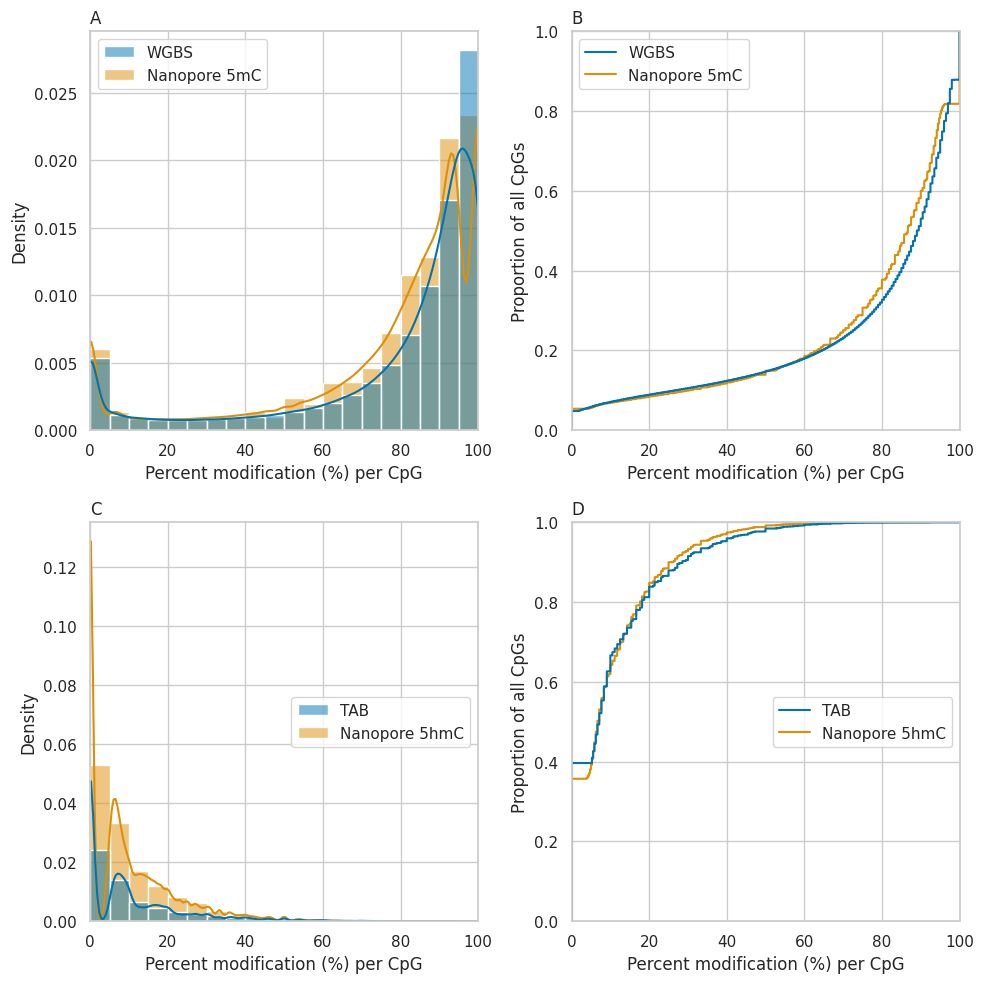

In [4]:
sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")

fig2 = pl.figure(figsize=(10, 10)) 
gs = fig2.add_gridspec(nrows=2, ncols=2)

ax1 = fig2.add_subplot(gs[0, 0])
ax2 = fig2.add_subplot(gs[0, 1])
ax3 = fig2.add_subplot(gs[1, 0])
ax4 = fig2.add_subplot(gs[1, 1])

sns.kdeplot(ecdf_df.loc[ecdf_df["modification_type"] == "5mC"], x="percentMeth", hue="method", ax=ax1, fill=False)
sns.histplot(ecdf_df.loc[ecdf_df["modification_type"] == "5mC"], x="percentMeth", hue="method", stat="density", binrange=(0, 100), bins=20, multiple="layer", ax=ax1)
sns.move_legend(ax1, "upper left", title=None)
ax1.set_xlabel("Percent modification (%) per CpG")
ax1.set_xlim([0, 100])
ax1.set_title("A", loc="left")

sns.ecdfplot(ecdf_df.loc[ecdf_df["modification_type"] == "5mC"], x="percentMeth", hue="method", ax=ax2)
sns.move_legend(ax2, "upper left", title=None)
ax2.set_ylabel("Proportion of all CpGs")
ax2.set_xlabel("Percent modification (%) per CpG")
# ax1.set_xticks(np.arange(0, 120, 20), labels=["0.0", "0.2", "0.4", "0.6", "0.8", "1.0"]) # to make proportions instead of percentages 
ax2.set_title("B", loc="left")
ax2.set_xlim([0, 100])

sns.kdeplot(ecdf_df.loc[ecdf_df["modification_type"] == "5hmC"], x="percentMeth", hue="method", common_norm=True, ax=ax3)
sns.histplot(ecdf_df.loc[ecdf_df["modification_type"] == "5hmC"], x="percentMeth", hue="method", stat="density", common_norm=True, binrange=(0, 100), bins=20, multiple="layer", ax=ax3)
sns.move_legend(ax3, "center right", title=None)
ax3.set_title("C", loc="left")
ax3.set_xlabel("Percent modification (%) per CpG")
ax3.set_xlim([0, 100])

sns.ecdfplot(ecdf_df.loc[ecdf_df["modification_type"] == "5hmC"], x="percentMeth", hue="method", ax=ax4)
sns.move_legend(ax4, "center right", title=None)
ax4.set_ylabel("Proportion of all CpGs")
ax4.set_xlabel("Percent modification (%) per CpG")
ax4.set_xlim([0, 100])
ax4.set_title("D", loc="left")

fig2.tight_layout()

In [3]:
from scipy import stats

anderson_res_mc = stats.anderson_ksamp([np.array(ecdf_df.loc[ecdf_df["method"] == "Nanopore 5mC"]["percentMeth"]), np.array(ecdf_df.loc[ecdf_df["method"] == "WGBS"]["percentMeth"])])
anderson_res_hmc = stats.anderson_ksamp([np.array(ecdf_df.loc[ecdf_df["method"] == "Nanopore 5hmC"]["percentMeth"]), np.array(ecdf_df.loc[ecdf_df["method"] == "TAB"]["percentMeth"])])

/tmp/ipykernel_260219/1994508982.py:3: UserWarning: p-value floored: true value smaller than 0.001
  anderson_res_mc = stats.anderson_ksamp([np.array(ecdf_df.loc[ecdf_df["method"] == "Nanopore 5mC"]["percentMeth"]), np.array(ecdf_df.loc[ecdf_df["method"] == "WGBS"]["percentMeth"])])
/tmp/ipykernel_260219/1994508982.py:4: UserWarning: p-value floored: true value smaller than 0.001
  anderson_res_hmc = stats.anderson_ksamp([np.array(ecdf_df.loc[ecdf_df["method"] == "Nanopore 5hmC"]["percentMeth"]), np.array(ecdf_df.loc[ecdf_df["method"] == "TAB"]["percentMeth"])])


In [4]:
anderson_res_mc.statistic, anderson_res_mc.pvalue

(8164.460730657421, 0.001)

In [5]:
anderson_res_hmc.statistic, anderson_res_hmc.pvalue

(376.2924430061321, 0.001)

In [6]:
stats.cramervonmises_2samp(np.array(ecdf_df.loc[ecdf_df["method"] == "Nanopore 5hmC"]["percentMeth"]), 
                           np.array(ecdf_df.loc[ecdf_df["method"] == "TAB"]["percentMeth"]))

CramerVonMisesResult(statistic=5453.855695905513, pvalue=6.498317890457628e-07)

In [7]:
stats.cramervonmises_2samp(np.array(ecdf_df.loc[ecdf_df["method"] == "Nanopore 5mC"]["percentMeth"]), 
                           np.array(ecdf_df.loc[ecdf_df["method"] == "WGBS"]["percentMeth"]))

CramerVonMisesResult(statistic=1134.6939132959233, pvalue=2.4647689145229634e-07)

In [8]:
from scipy import stats

def kolmogorov_smirnov(nano_df, bench_df):
    nano_array =  np.sort(filter_on_depth(nano_df)["percentMeth"].to_numpy())
    bench_array = np.sort(filter_on_depth(bench_df)["percentMeth"].to_numpy())

    return stats.kstest(nano_array, bench_array)

nano_5mc_array =  filter_on_depth(nano_mc_df)["percentMeth"].to_numpy()
wgbs_array = filter_on_depth(wgbs_df)["percentMeth"].to_numpy()

stats.kstest(rvs=nano_5mc_array, cdf=wgbs_array)


KstestResult(statistic=0.08674925295338687, pvalue=0.0, statistic_location=94.74, statistic_sign=1)

In [9]:
kolmogorov_smirnov(nano_mc_df, wgbs_df)

KstestResult(statistic=0.08674925295338687, pvalue=0.0, statistic_location=94.74, statistic_sign=1)

In [10]:
kolmogorov_smirnov(nano_hmc_df, tab_df)

KstestResult(statistic=0.03565108398218708, pvalue=4.654467682235e-311, statistic_location=7.14, statistic_sign=1)

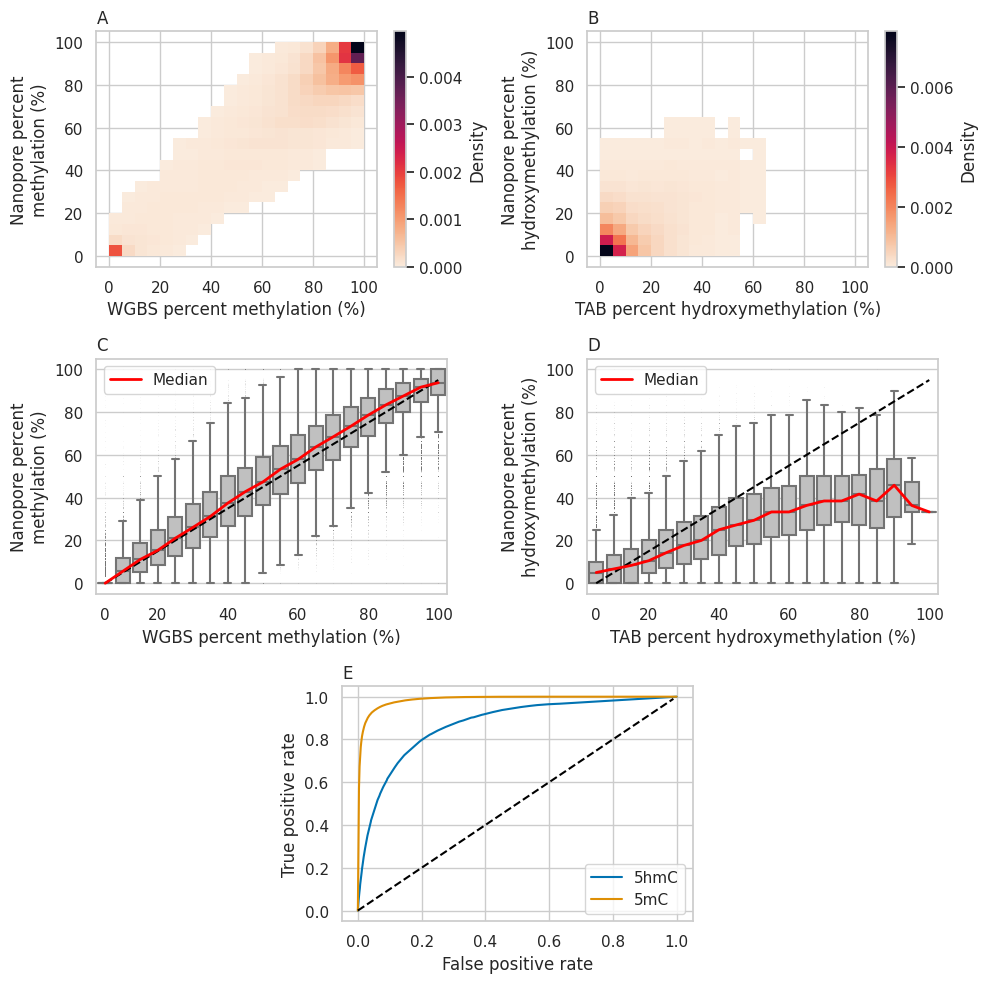

In [11]:
from matplotlib.gridspec import GridSpec

sns.set_theme(style="whitegrid")
sns.set_palette("colorblind")

fig1 = pl.figure(figsize=(10, 10)) 
gs1 = GridSpec(3, 4, fig1)

ax1 = fig1.add_subplot(gs1[0, :2])
ax2 = fig1.add_subplot(gs1[0, 2:])
ax3 = fig1.add_subplot(gs1[1, :2])
ax4 = fig1.add_subplot(gs1[1, 2:])

sns.histplot(merged_5mc_df, x="percentMeth_WGBS", y="percentMeth_Nano", cmap="rocket_r", bins=20, pthresh=0.01, cbar=True, stat="density", ax=ax1, cbar_kws=dict(label="Density"))
ax1.set_xlabel("WGBS percent methylation (%)")
ax1.set_ylabel("Nanopore percent\nmethylation (%)")
ax1.set_title("A", loc="left")

sns.histplot(merged_5hmc_df, x="percentMeth_TAB", y="percentMeth_Nano", cmap="rocket_r", bins=20, pthresh=0.01, cbar=True, stat="density", ax=ax2, cbar_kws=dict(label="Density"))
ax2.set_xlabel("TAB percent hydroxymethylation (%)")
ax2.set_ylabel("Nanopore percent\nhydroxymethylation (%)")
ax2.set_title("B", loc="left")

sns.boxplot(merged_5mc_df, x="WGBS_bin", y="percentMeth_Nano", color="silver", fliersize=0.01, flierprops={"marker":"x"}, ax=ax3)
ax3.plot(np.arange(0, 20, 1), np.arange(0, 100, 5), linestyle="dashed", color="black", zorder=5)
ax3.set_xticks([0, 3, 7, 11, 15, 19], labels=["0", "20", "40", "60", "80", "100"])
ax3.set_xlabel("WGBS percent methylation (%)")
ax3.set_ylabel("Nanopore percent\nmethylation (%)")
ax3.plot(np.arange(0, 20, 1), mc_lineplot_df["percentMeth_Nano"], color="red", linewidth=2, label="Median", zorder=10)
ax3.legend()
ax3.set_title("C", loc="left")
sns.move_legend(ax3, "upper left")

sns.boxplot(merged_5hmc_df, x="TAB_bin", y="percentMeth_Nano", color="silver", fliersize=0.01, flierprops={"marker":"x"}, ax=ax4)
ax4.plot(np.arange(0, 20, 1), np.arange(0, 100, 5), linestyle="dashed", color="black", zorder=5)
ax4.set_xticks([0, 3, 7, 11, 15, 19], labels=["0", "20", "40", "60", "80", "100"])
ax4.set_xlabel("TAB percent hydroxymethylation (%)")
ax4.set_ylabel("Nanopore percent\nhydroxymethylation (%)")
ax4.plot(np.arange(0, 20, 1), hmc_lineplot_df["percentMeth_Nano"], color="red", linewidth=2, label="Median", zorder=10)
ax4.legend()
ax4.set_title("D", loc="left")
sns.move_legend(ax4, "upper left")

ax5 = fig1.add_subplot(gs1[2, 1:3])
ax5.plot(hmc_fpr, hmc_tpr, '-', label="5hmC")
ax5.plot(mc_fpr, mc_tpr, '-', label="5mC")
ax5.set_xlabel("False positive rate")
ax5.set_ylabel("True positive rate")
ax5.plot(np.arange(0, 1, 0.01), np.arange(0, 1, 0.01), "black", linestyle="--")
ax5.legend()
ax5.set_title("E", loc="left")

fig1.tight_layout()